# Parallel Computing

## General thoughts

Parallel computing is a programming method that **harnesses the power of multiple processors (typically CPU cores) at once**.

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism** (e.g. SIMD)
* **Multi-threading** (shared memory)
* **Multi-processing** (shared system memory)
* **Distributed processing** (typically no shared memory)

**Import note before we start: At the center of an efficient parallel code is a fast serial code!!**

### Why go parallel?

<img src="../imgs/42-years-processor-trend.svg" width=700px>

### When to go parallel?

* If parts of your (optimized!) serial code aren't fast enough.
  * note that parallelization typically increases the code complexity
* If your system has multiple execution units (CPU threads, GPU threads, ...).
  * particularly import on large supercomputers but also already on modern desktop computers and laptops.

### How many CPU threads / cores do I have?

In [8]:
using Hwloc
Hwloc.num_physical_cores()

6

Note that there may be more than one CPU thread per physical CPU core (e.g. hyperthreading).

In [9]:
Sys.CPU_THREADS

12

### How many CPU threads / cores does Hawk have?

[Hawk has about 720k CPU cores!](https://www.hlrs.de/solutions/systems/hpe-apollo-hawk)

Even if you only use a single node you have access to 128 CPU cores (64 per CPU). Hence, if you would use only a single core, the node utilization would be less than 1%.

### Amdahl's law

Naive strong scaling expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by
>$$ F(n) = 1/(1-p + p/n) $$

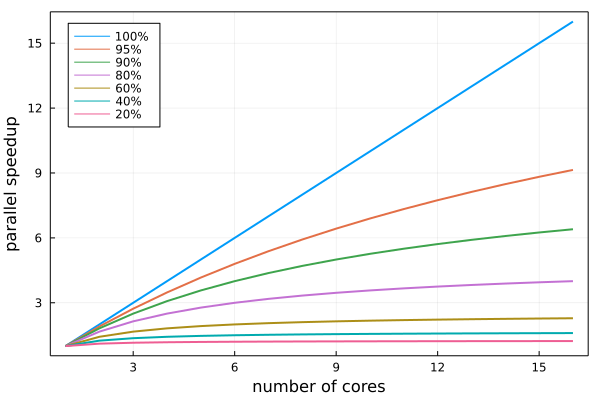

In [12]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

### [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/) in Julia

Julia provides support for all types of parallelism mentioned above (same order)

* `@simd`, [SIMD.jl](https://github.com/eschnett/SIMD.jl), [LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)
* `Threads.@threads`, `Threads.@spawn`, [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl), [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl) ...
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`
* `@spawnat`, `@fetch`, `RemoteChannel`, [DistributedArrays.jl](https://github.com/JuliaParallel/DistributedArrays.jl), [MPI.jl](https://github.com/JuliaParallel/MPI.jl)

With supercomputing in mind, we will start by focusing on multi-process parallelism which allows us to utilize multiple cores on the same or different nodes/machines (distributed computing).

But before we do, it's instructive to take a closer look at **tasks**.

## Tasks

By default, Julia waits for every command to finish ("**blocking**") and run everything sequentially.

**Tasks** are a control flow feature that allows computations to be suspended and resumed in a flexible manner to implement **cooperative multitasking**. (This feature is sometimes called by other names, such as coroutines, green-, or lightweight threads.)

Tasks are managed by Julia and can be run in a **concurrent** fashion.

> **Concurrency** means executing multiple tasks at the same time but not necessarily simultaneously.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes**

## `@async` and `@sync`

We can create and schedule a task for asynchronous execution with the [`@async` macro](https://docs.julialang.org/en/v1/base/parallel/#Base.@async).

What this means is that for whatever falls into its scope, Julia will start a task to then proceed to whatever comes next in the script without waiting for the task to complete ("**non-blocking**").

In [15]:
@time sleep(2);

  2.003423 seconds (67 allocations: 1.984 KiB)


In [16]:
@time @async sleep(2)

  0.045481 seconds (347 allocations: 18.117 KiB, 49.01% compilation time)


Task (runnable) @0x000000015a7a0010

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the partner macro `@sync` to synchronize, that is wait for all encapsulated tasks. (see `?@sync`). 

In [17]:
@time @sync @async sleep(2)

  2.042346 seconds (797 allocations: 47.032 KiB, 1.97% compilation time)


Task (done) @0x000000015a5ee8c0

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether. A better example is the following.

In [18]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.015457 seconds (1.03 k allocations: 62.816 KiB, 0.70% compilation time)


Task (done) @0x000000015a5ef0a0

In [43]:
A = rand(1000,1000)
B = rand(1000,1000)

t = @async A * B

Task (done) @0x000000015c3b39d0

In [47]:
wait(t)

In [46]:
fetch(t)

1000×1000 Matrix{Float64}:
 259.579  249.371  252.671  252.4    …  252.258  255.788  248.794  252.095
 258.117  248.715  255.078  250.739     250.534  252.483  252.958  253.441
 255.147  249.576  246.675  252.611     249.121  254.86   254.392  257.814
 269.464  258.722  268.374  267.267     263.156  259.958  260.838  263.588
 254.854  244.653  248.673  249.735     248.548  249.762  246.197  255.217
 262.137  250.495  255.397  261.741  …  254.82   257.16   256.593  257.744
 252.194  247.918  248.61   245.312     242.74   247.678  246.156  249.587
 260.485  255.115  255.665  252.205     250.7    256.493  256.794  260.945
 253.913  249.635  251.917  249.857     248.714  250.924  249.177  253.258
 262.309  250.814  254.294  257.102     255.43   256.36   255.171  258.401
   ⋮                                 ⋱                             
 246.879  244.601  247.962  245.98      242.762  248.652  242.878  245.552
 255.373  249.518  257.054  256.095     254.21   252.042  254.116  259.491
 259.